In [1]:
from flash_ansr import FlashANSR, GenerationConfig, install_model, get_path
 
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from drawdata import ScatterWidget

In [3]:
# MODEL = "psaegert/flash-ansr-v21.0-60M"
MODEL = "ansr-models/v22.0-60M" # /checkpoint_250000

In [4]:
# install_model(MODEL)

In [28]:
nsr = FlashANSR.load(
    directory=get_path('models', MODEL),
    # generation_config=GenerationConfig(method='beam_search', beam_width=1024 * 32, equivalence_pruning=True),
    generation_config=GenerationConfig(method='softmax_sampling', choices=1024, max_len=48),
    # generation_config=GenerationConfig(method='mcts', beam_width=1024, simulations=1024 * 32, temperature=1),
    parsimony=0.02
).to(device)

In [6]:
widget = ScatterWidget()
widget

ScatterWidget()

In [8]:
X_raw, y_raw = widget.data_as_X_y

# Scale X_raw and y_raw to (-10, 10)
X = (X_raw - X_raw.min(axis=0)) / (X_raw.max(axis=0) - X_raw.min(axis=0)) * 20 - 10
y = (y_raw - y_raw.min(axis=0)) / (y_raw.max(axis=0) - y_raw.min(axis=0)) * 20 - 10

In [49]:
nsr.fit(X, y, verbose=True, complexity=30)

Fitting Constants: 100%|██████████| 5/5 [00:00<00:00, 2453.96it/s]


In [50]:
nsr.compile_results(parsimony=0.02)

In [51]:
nsr.get_expression(0)

'1.69 * pow4(0.96 * x3)'

In [52]:
nsr.results

,log_prob,fvu,score,expression,complexity,target_complexity,numeric_prediction,raw_beam,beam,raw_beam_decoded,function,refiner,prompt_metadata,beam_id,fit_constants,fit_covariances,fit_loss
0,-39.548279,1.03395,0.1345,"[*, <constant>, pow4, *, <constant>, x3]",6,30,None,"[1, 7, 11, 13, 12, 8, 9, 30, 6, 38, 30, 6, 68,...","[30, 6, 38, 30, 6, 68]","[*, <constant>, pow4, *, <constant>, x3, mult5...",<function <lambda> at 0x7d0c03159300>,"Refiner(expression=['*', '<constant>', 'pow4',...","{'allowed_terms': [], 'include_terms': [], 'ex...",0,"[1.69242868432192, 0.9583349441114166]","[[inf, inf], [inf, inf]]",51.128451
1,-113.565697,1.03395,0.1545,"[/, pow1_5, x20, *, <constant>, cosh, x9]",7,30,None,"[1, 7, 11, 13, 12, 8, 9, 31, 43, 85, 30, 6, 51...","[31, 43, 85, 30, 6, 51, 74]","[/, pow1_5, x20, *, <constant>, cosh, x9, atan...",<function <lambda> at 0x7d0c0315be20>,"Refiner(expression=['/', 'pow1_5', 'x20', '*',...","{'allowed_terms': [], 'include_terms': [], 'ex...",1,[0.5164191497955783],[[inf]],51.128451


In [24]:
X_linspace = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

In [25]:
y_pred = [[nsr.predict(X, nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result['fits'])) if np.isfinite(result['score'])] for beam_id, result in enumerate(nsr._results)]
y_pred_linspace = [[nsr.predict(X_linspace, nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result['fits'])) if np.isfinite(result['score'])] for beam_id, result in enumerate(nsr._results)]

/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:173: RuntimeWarning: invalid value encountered in power
  x = np.where(x < 0, -(-x) ** (1 / 5), x ** (1 / 5))
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:546: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


In [26]:
y_pred = y_pred[:32]
y_pred_linspace = y_pred_linspace[:32]

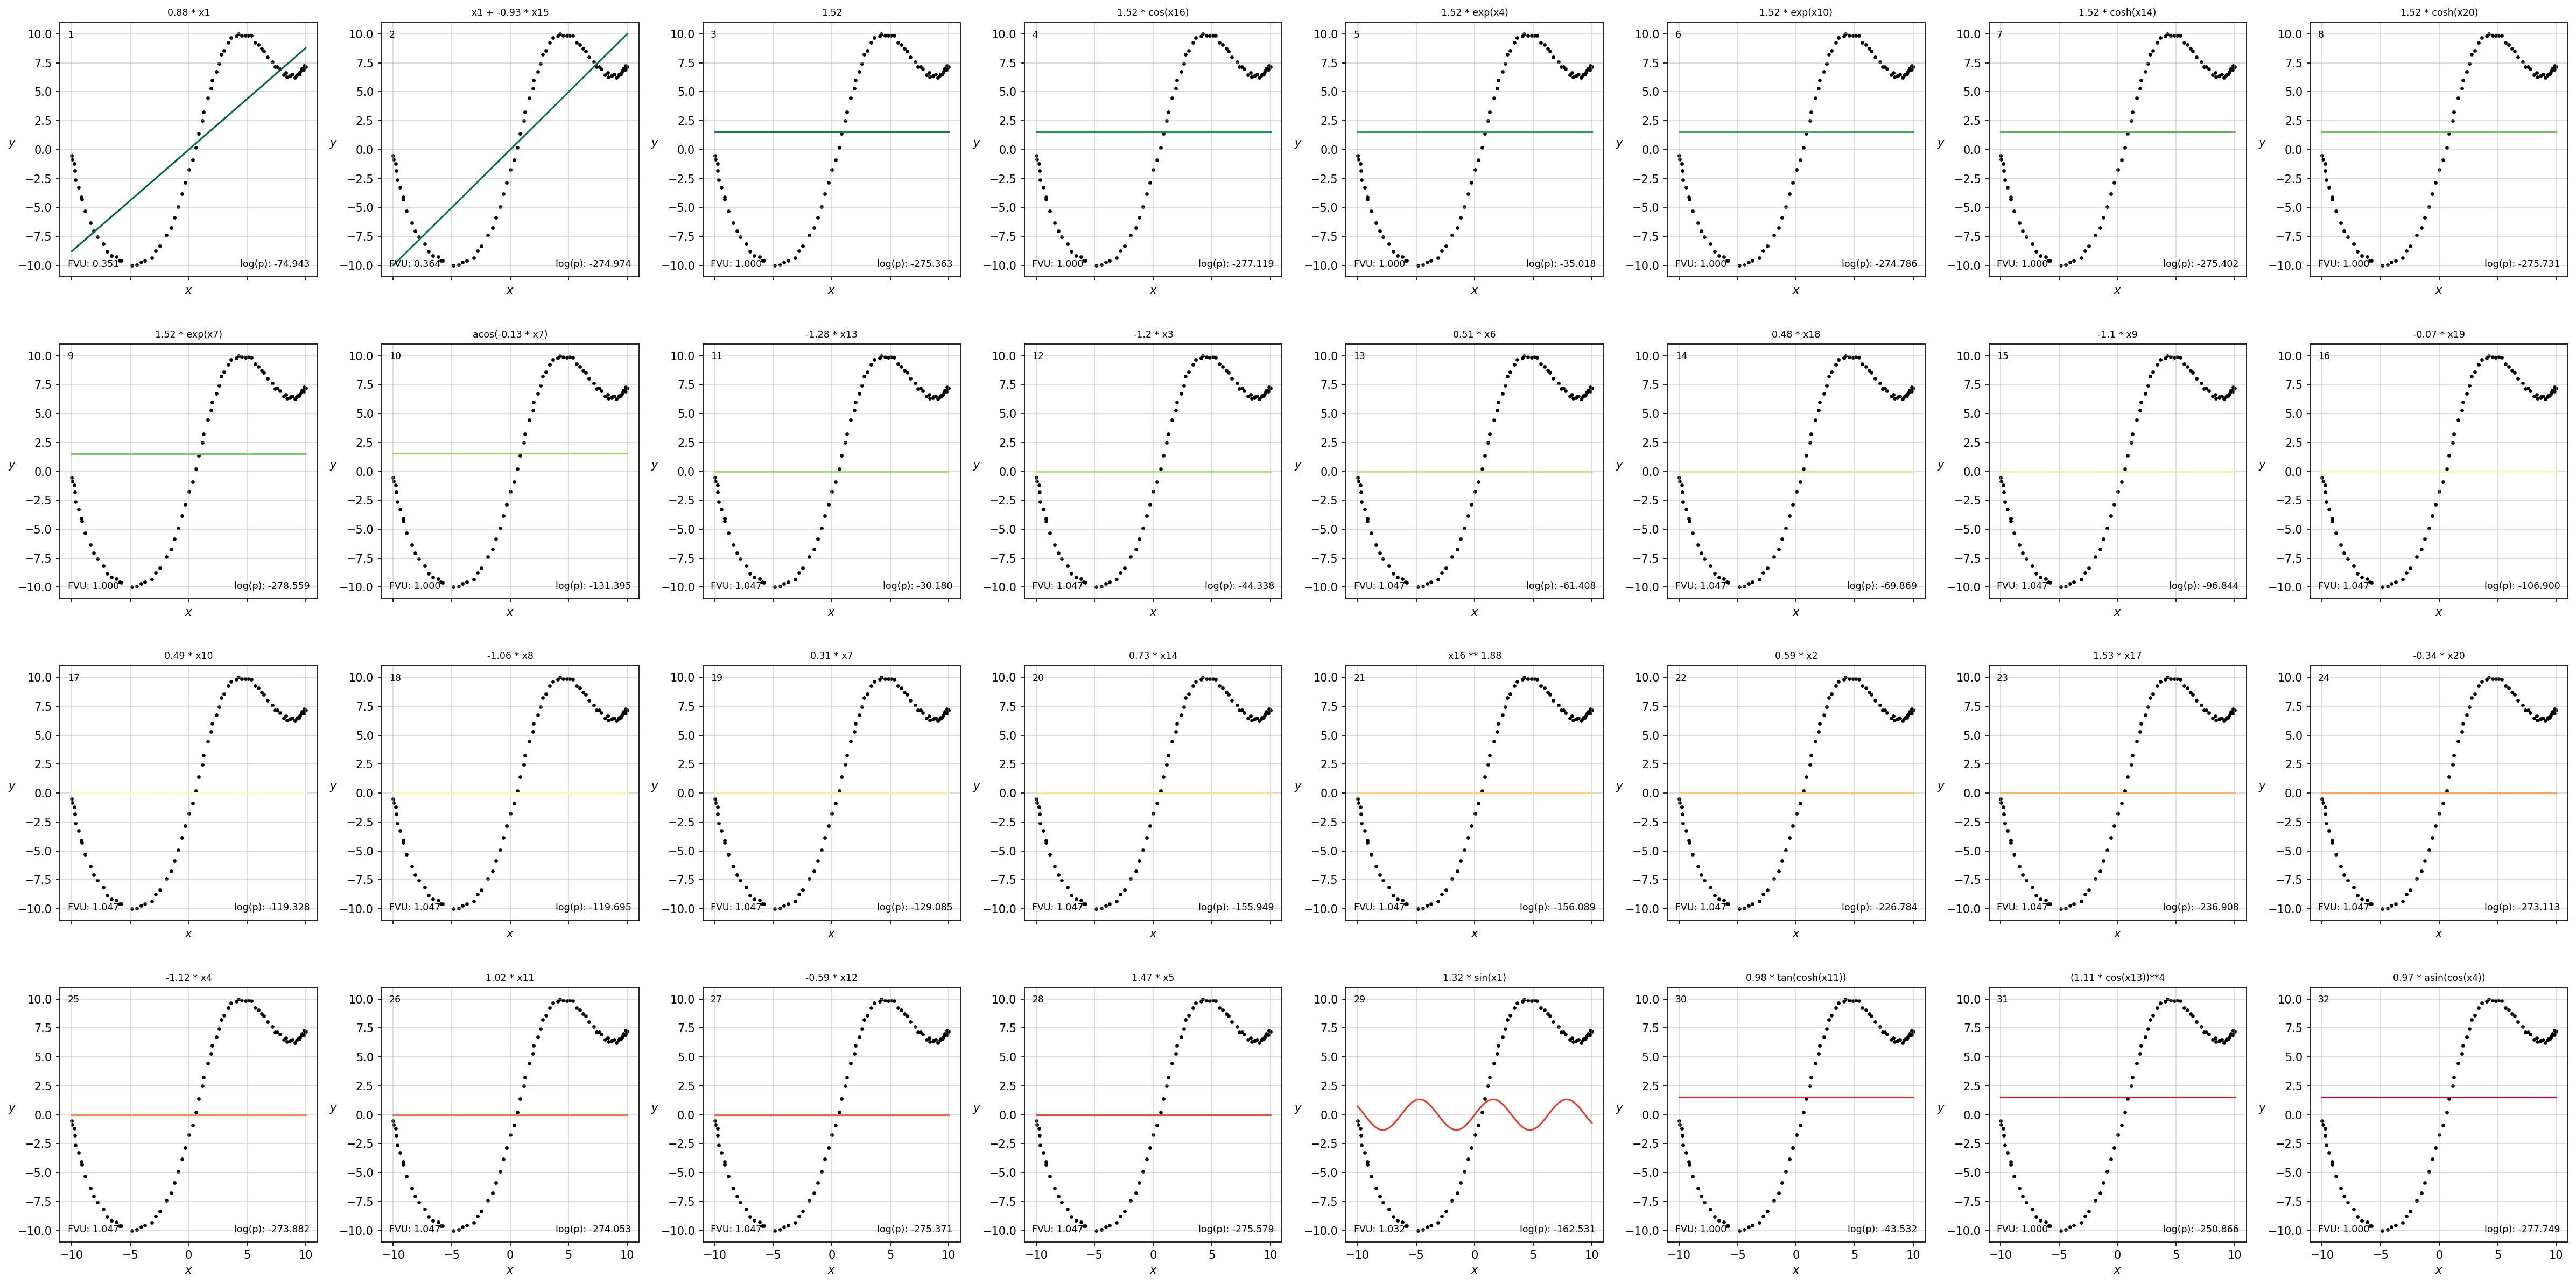

In [27]:
COLS = 8
ROWS = np.ceil(len(y_pred) / COLS).astype(int)

fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 4), dpi=150, sharex=True)

for i, ax in enumerate(axs.flat):
    if i >= len(y_pred) or len(y_pred[i]) == 0:
        ax.axis('off')
        continue
    fvu = np.mean((y_pred[i][0][:, 0] - y)**2) / np.var(y)
    expression_pred_transformed = nsr._results[i]['refiner'].transform(nsr._results[i]['expression'], 0, return_prefix=True)
    expression_pred_transformed_infix = nsr.simplipy_engine.prefix_to_infix(expression_pred_transformed, power='**')

    ax.plot(X_linspace, y_pred_linspace[i][0], color=plt.get_cmap('RdYlGn')(1 - i / len(y_pred)))
    ax.scatter(X, y, color='k', s=5)
    ax.set_title(expression_pred_transformed_infix, fontsize='small')
    
    ax.annotate(f'{i + 1}', xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top', fontsize='small')
    ax.annotate(f'FVU: {fvu:.3f}', xy=(0.03, 0.03), xycoords='axes fraction', ha='left', va='bottom', fontsize='small')
    ax.annotate(f'log(p): {nsr._results[i]["log_prob"]:.3f}', xy=(0.97, 0.03), xycoords='axes fraction', ha='right', va='bottom', fontsize='small')

    ax.grid(alpha=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$', rotation=0, labelpad=5)

fig.tight_layout(h_pad=3)

Text(0, 0.5, 'Log Probability')

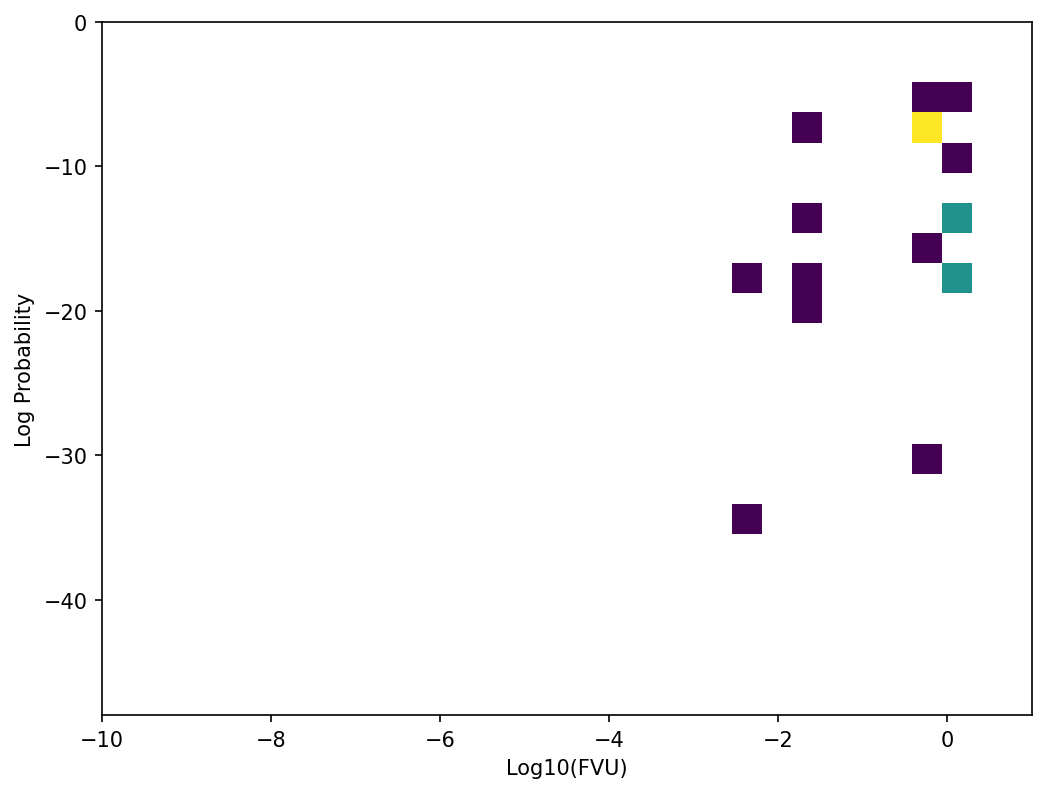

In [19]:
# plot the fvu against the complexity
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist2d(np.log10(nsr.results['fvu']), nsr.results['log_prob'], bins=(np.linspace(-10, 1, 32), np.linspace(-48, 0, 24)), cmin=1);
ax.set_xlabel('Log10(FVU)')
ax.set_ylabel('Log Probability')

Text(0, 0.5, 'Log Probability')

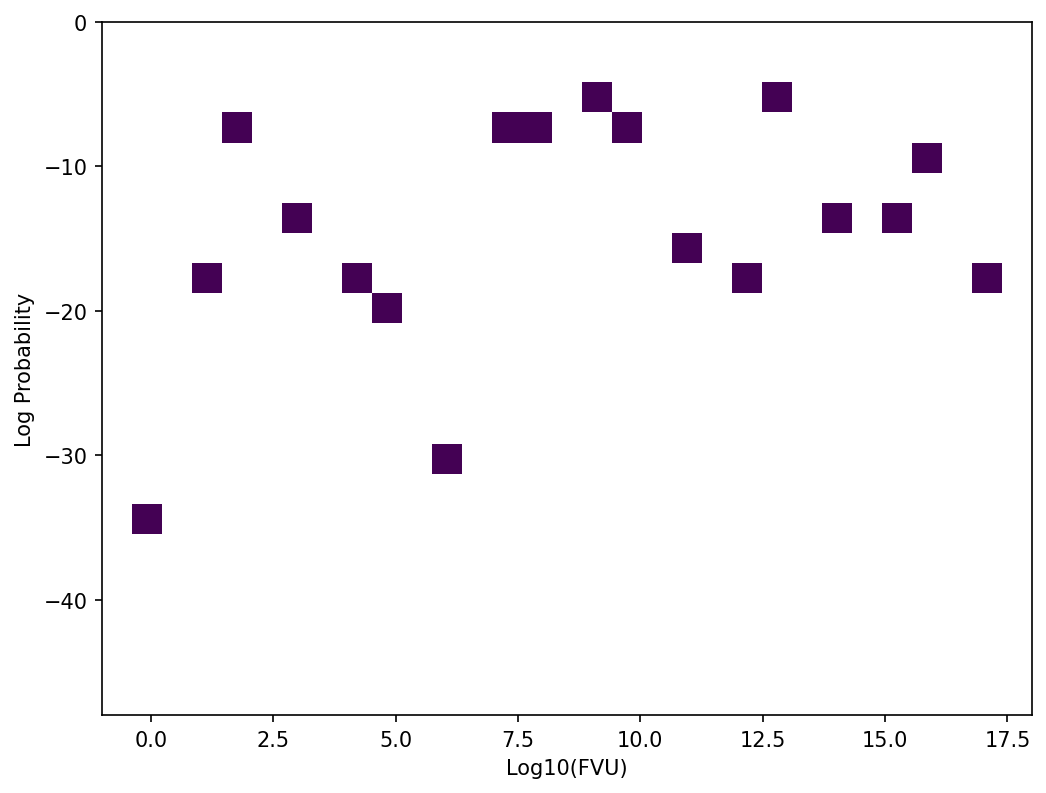

In [20]:
# plot the fvu against the complexity
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist2d(np.argsort(nsr.results['fvu']), nsr.results['log_prob'], bins=(np.linspace(-1, len(nsr.results), 32), np.linspace(-48, 0, 24)), cmin=1);
ax.set_xlabel('Log10(FVU)')
ax.set_ylabel('Log Probability')

Text(0, 0.5, 'Complexity')

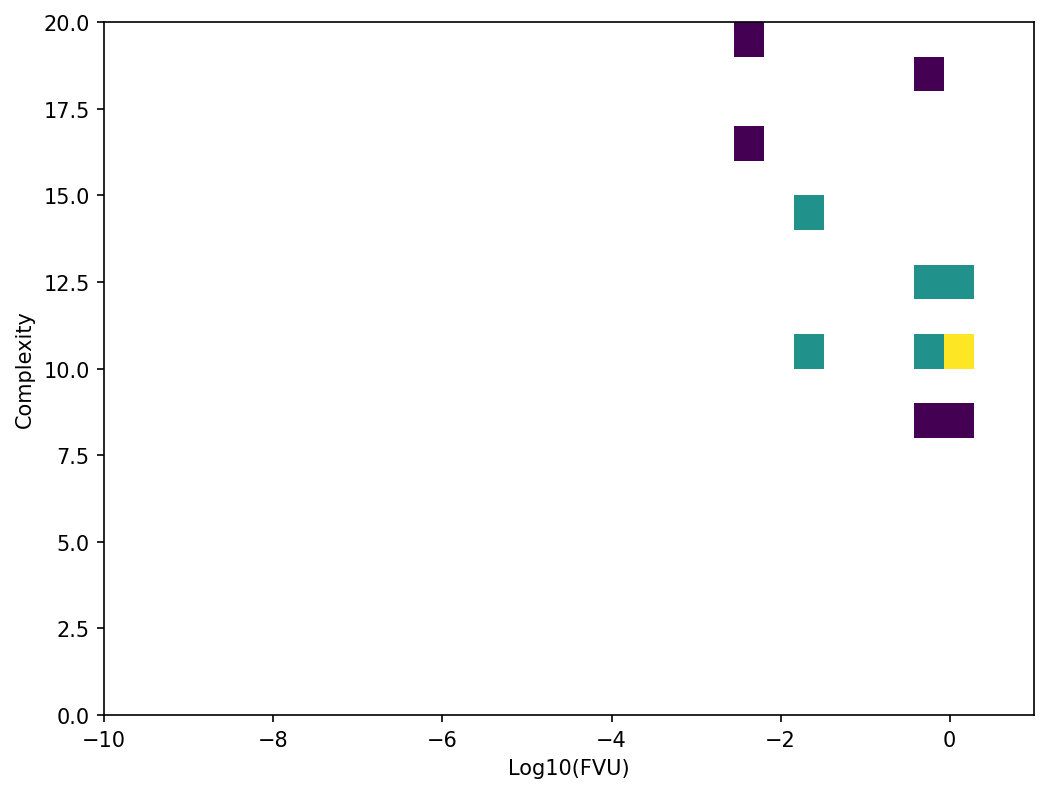

In [21]:
# plot the fvu against the complexity
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist2d(np.log10(nsr.results['fvu']), nsr.results['complexity'], bins=(np.linspace(-10, 1, 32), np.linspace(0, 20, 21)), cmin=1);
ax.set_xlabel('Log10(FVU)')
ax.set_ylabel('Complexity')